In [ ]:
!sudo apt-get install python3-numpy python3-scipy liblapack-dev libatlas-base-dev libgsl0-dev fftw-dev libglpk-dev libdsdp-dev

In [ ]:
!pip install mdptoolbox-hiive

In [ ]:
import numpy as np
np.random.seed(0)

In [ ]:
!pip install "pymdptoolbox[LP]"


In [ ]:
!pip install plotting

In [ ]:
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
import plotting
  
from collections import defaultdict



In [ ]:
import gym
#import mdptoolbox


In [ ]:
import mdptoolbox

In [ ]:
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import plotting

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [ ]:
#https://www.novatec-gmbh.de/en/blog/introduction-to-q-learning/
def testQ(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.4, eps_decay = 0.9995, alpha_decay = .99995,steps = 100):
  state_space = env.observation_space.n
  action_space = env.action_space.n
  #qtable = np.random.random_sample((state_space, action_space))
  qtable = np.zeros((state_space, action_space))
  epsilon = epsilon           #Greed 100%
 
  epsilon_min = 0.005     #Minimum greed 0.05%
  
  epsilon_decay = eps_decay #Decay multiplied with epsilon after each episode
  
  episodes = num_episodes        #Amount of games
  
  max_steps = steps         #Maximum steps per episode
  
  learning_rate = 0.65
  convergeCount = 0
  gamma = 0.65
  stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes)) 
  delta = np.zeros((num_episodes,2))
  qOld = qtable.copy()
  for episode in range(num_episodes):
    
    # Reset the game state, done and score before every episode/game
    state = env.reset() #Gets current game state
    done = False        #decides whether the game is over
    score = 0
    
 
    for t in range(max_steps):
 
        # With the probability of (1 - epsilon) take the best action in our Q-table
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(qtable[state, :])
        # Else take a random action
        else:
            action = env.action_space.sample()
        
        # Step the game forward
        next_state, reward, done, _ = env.step(action)
        if done and reward == 0:
              reward = -1
        elif not(done) and reward == 0:
          reward = -.01
        
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = t
        # Add up the score
        score += reward
 
        # Update our Q-table with our Q-function
        #Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) — Q[state, action])
        
        qtable[state, action] = ((1 - learning_rate) * qtable[state, action]) + (learning_rate * (reward + gamma * np.max(qtable[next_state,:])))
        
 
        # Set the next state as the current state
        state = next_state
 
        if done:
            
            break
        
 
    # Reducing our epsilon each episode (Exploration-Exploitation trade-off)
    delta[episode,0] = np.mean(np.absolute(qtable-qOld))
    delta[episode,1] = alpha
    qOld = qtable.copy()
    if learning_rate>=.05:
      learning_rate*= alpha_decay
    if epsilon >= epsilon_min:
        epsilon *= epsilon_decay
    else:
      print(episode)
      break
  print(epsilon)
  return qtable, stats, delta

In [ ]:
def experiment(enviro, size, discount = .99, epsilon = .001):
  enviro.render()
  
  R = np.zeros((enviro.action_space.n,enviro.observation_space.n, enviro.observation_space.n))
  T = np.zeros((enviro.action_space.n,enviro.observation_space.n,  enviro.observation_space.n))
  for s in range(enviro.observation_space.n):
      for a in range(enviro.action_space.n):
          for transition in enviro.env.P[s][a]:
              probability, next_state, reward, done = transition
              if reward == 0 and done:
                #print("Neg reward")
                reward = -1
              R[a, s, next_state] = reward
              T[a, s, next_state] += probability

  policy = mdptoolbox.mdp.PolicyIteration(T,R,discount,max_iter=15000)
  #policy.setVerbose() 
  policy.run()
  print("Number of Iters in Policy Iteration")
  print(policy.iter)
  print("CPU Time in Policy Iteration")
  print(policy.time)
  print("Policy resulting from Policy Iteration")
  print(np.reshape(policy.policy,(size,size)))
  policy2 = mdptoolbox.mdp.ValueIteration(T,R,discount, epsilon=epsilon)
  #policy2.setVerbose()
  policy2.run()
  print("Policy resulting from Value Iteration")
  print(np.reshape(policy2.policy,(size,size)))
  print("Number of Iters in Value Iteration")
  print(policy2.iter)
  print("CPU Time in Value Iteration")
  print(policy2.time)
  print("Total number of SAME ACTIONS in policy")
  print(str((np.asarray(policy.policy) == np.asarray(policy2.policy)).sum()) + "/" + str(size*size))


In [ ]:
def qForest(env, num_episodes, fire = .1, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 1, alpha_decay = .9995,eps_decay = .9993):
  state_space = env
  action_space = 2
  #qtable = np.random.random_sample((state_space, action_space))
  qtable = np.zeros((state_space, action_space))
  P, R = mdptoolbox.example.forest(S=env,r1 = 20)
  if num_episodes<2:
    print(P)
    print(R)
  epsilon = epsilon           #Greed 100%
 
  epsilon_min = 0.005     #Minimum greed 0.05%
  
  epsilon_decay = eps_decay #Decay multiplied with epsilon after each episode
  
  episodes = num_episodes        #Amount of games
  
  max_steps = state_space * 10         #Maximum steps per episode
  
  learning_rate = alpha
  convergeCount = 0
  gamma = 0.65
  stats = EpisodeStats(
        episode_lengths = np.zeros(num_episodes),
        episode_rewards = np.zeros(num_episodes)) 
  delta = np.zeros(num_episodes)
  qOld = qtable.copy()
  for episode in range(num_episodes):
    
    # Reset the game state, done and score before every episode/game
    state = 0 #Gets current game state
    done = False        #decides whether the game is over
    score = 0
    
 
    for t in range(max_steps):
 
        # With the probability of (1 - epsilon) take the best action in our Q-table
        if np.random.uniform(0, 1) > epsilon:
            action = np.argmax(qtable[state, :])
        # Else take a random action
        else:
            action = np.random.randint(0,2)
        
        # Step the game forward
        
        if action == 0 and np.random.uniform(0,1) > fire:
          next_state = state+1
          reward = R[state,action]
        else:
          next_state = 0
          reward = R[state,action]
        if next_state == state_space:
          next_state = state_space-1
        
        stats.episode_rewards[episode] += reward
        stats.episode_lengths[episode] = t
        # Add up the score
        score += reward
 
        # Update our Q-table with our Q-function
        #Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) — Q[state, action])
        
        qtable[state, action] = ((1 - learning_rate) * qtable[state, action]) + (learning_rate * (reward + gamma * np.max(qtable[next_state,:])))
        if next_state == state:
          break
 
        # Set the next state as the current state
        state = next_state
        
 
    # Reducing our epsilon each episode (Exploration-Exploitation trade-off)
    delta[episode] = np.mean(np.absolute(qtable-qOld))
    qOld = qtable.copy()
    if learning_rate>=.05:
      learning_rate*= alpha_decay
    if epsilon >= epsilon_min:
        epsilon *= epsilon_decay
    else:
      print(episode)
      break
  print(epsilon)
  return qtable, stats, delta

In [ ]:
from gym import envs
from gym.envs.toy_text.frozen_lake import generate_random_map
np.random.seed(0)
lakeSize = 30
random_map = generate_random_map(size=lakeSize, p=0.8)
 
enviro = gym.make("FrozenLake-v0", desc=random_map)
enviro.reset()
print(enviro.action_space.sample())

#enviro.render()
#print(enviro.env.P)


1


In [ ]:
np.random.seed(0)
lakeSize2 = 10
random_map = generate_random_map(size=lakeSize2, p=0.8)
 
enviro2 = gym.make("FrozenLake-v0", desc=random_map)
enviro2.reset()

0

In [ ]:
np.random.seed(0)
lakeSize2 = 10
random_map = generate_random_map(size=lakeSize2, p=0.8)
 
enviro5 = gym.make("FrozenLake-v0", desc=random_map)
enviro5.reset()
experiment(enviro5,lakeSize2,discount = .5)


SFFHFFFFFH
FHFFHFHFHF
FFHFFFFFFF
FFFFFFFFFF
HFFHHFFHFH
FHFFFHHFFF
FFFHHHFFFF
FFFFFFFHFF
FFFFHFFFFF
FFFHFFFFFG
Number of Iters in Policy Iteration
3
CPU Time in Policy Iteration
0.003337383270263672
Policy resulting from Policy Iteration
[[0 3 0 0 2 2 3 0 0 0]
 [0 0 2 0 0 0 0 0 0 1]
 [0 0 0 2 1 1 1 1 1 1]
 [3 3 1 3 3 3 3 3 3 3]
 [0 2 0 0 0 2 0 0 0 0]
 [0 0 2 1 0 0 0 1 2 1]
 [1 1 0 0 0 0 1 3 2 1]
 [1 1 0 1 1 1 0 0 2 1]
 [1 0 0 0 0 2 1 1 1 1]
 [0 0 0 0 1 2 2 2 2 0]]
Policy resulting from Value Iteration
[[0 3 0 0 2 2 3 0 0 0]
 [0 0 2 0 0 0 0 0 0 1]
 [0 0 0 2 1 1 1 1 1 1]
 [3 3 1 3 3 3 3 3 3 3]
 [0 2 0 0 0 2 0 0 0 0]
 [0 0 2 1 0 0 0 1 2 1]
 [1 1 0 0 0 0 1 3 2 1]
 [1 1 0 1 1 1 0 0 2 1]
 [1 0 0 0 0 2 1 1 1 1]
 [0 0 0 0 1 2 2 2 2 0]]
Number of Iters in Value Iteration
11
CPU Time in Value Iteration
0.0008304119110107422
Total number of SAME ACTIONS in policy
100/100


In [ ]:
experiment(enviro2,lakeSize2,discount = .99)


SFFHFFFFFH
FHFFHFHFHF
FFHFFFFFFF
FFFFFFFFFF
HFFHHFFHFH
FHFFFHHFFF
FFFHHHFFFF
FFFFFFFHFF
FFFFHFFFFF
FFFHFFFFFG
Number of Iters in Policy Iteration
15000
CPU Time in Policy Iteration
14.33474588394165
Policy resulting from Policy Iteration
[[0 3 0 0 2 2 3 0 3 0]
 [0 0 2 1 0 0 0 0 0 2]
 [0 1 0 2 1 1 1 1 1 1]
 [3 3 1 3 3 3 3 3 3 3]
 [0 2 0 0 0 2 0 0 2 0]
 [1 0 2 1 3 0 0 1 2 1]
 [1 1 0 0 0 0 2 3 2 1]
 [1 1 0 1 1 1 0 0 2 1]
 [1 0 0 3 0 2 1 1 1 3]
 [0 0 0 0 1 2 2 2 0 0]]
Policy resulting from Value Iteration
[[0 3 0 0 2 2 3 0 0 0]
 [0 0 2 0 0 0 0 0 0 1]
 [0 0 0 2 1 1 1 1 1 1]
 [3 3 1 3 3 3 3 3 3 3]
 [0 2 0 0 0 2 0 0 0 0]
 [0 0 2 1 0 0 0 1 2 1]
 [1 1 0 0 0 0 1 3 2 1]
 [1 1 0 1 1 1 0 0 2 1]
 [1 0 0 0 0 2 1 1 1 3]
 [0 0 0 0 1 2 2 2 0 0]]
Number of Iters in Value Iteration
903
CPU Time in Value Iteration
0.0633840560913086
Total number of SAME ACTIONS in policy
91/100


In [ ]:
experiment(enviro,lakeSize,discount = .5)


SFFFFFFHHFFFFHFFFHFHHFFFFFFHFF
FFFFFFFFHFFFFFFFFFFFFFHFFFFFFF
FFFFFFHFHFHFHFFFFFFFFFFFFFFFFH
FFFFFFFFHFFFFHFFFFFHFHFFHFHFHF
FFHFFFFFFFFFFFFFFFFFHFFHHFFHFH
FHFFFHHFFFFFFHHHFFFFFFFFFFFHFF
FFFFHFFFFFFFFHFFFFFFFFFFFFFFFH
HFFFFFFFFHFHFFFHFFHFFFFFFFFFFF
HFFFFFFFFFFHFFHFFFHFFFFHFFFFFF
HHFHFHHFFHFHFFFFHFFFFFHFFFFHHH
HFFFFFFFFFFFFFFFFFHFFFFFFFFFFF
FFFFFFFFFFFFFFFFFFFHFFFFFFFFFH
FHFFHFFFHFFFFFFFFHFFHFHFHHHFFF
FFFHFHFFFFFHFHHFFFFFFFFFFFFFFF
HHFFFFHFFFFFFFFFFFFFFHHFFFHHHH
FHFFHFFFFHFFFFFFFFHFFHFHHFFHHF
FFFFFFFHHFFFHFFFFFFFFFFFFHHFFF
FFFFFFFFFHFFFFFFFHFFFFFFFFFFFH
FFFFHFFHFFFFFFFFFFFHFFHHFHFHHH
HFFFHFFHFHFFFFFFFFFHFHFFFHFFFH
FFFFFFFFFFFFHFFFFFFHFFFHHHFFFF
FFFFFHFFFFHHHFFFFFHFFFFFHFFFFH
FHFFFFFFFFFFFFHFFFFFFFFFFFFFHF
HFFFFFFFFHFFFFFFFFFHFFFFFFFFFF
FHFHFHFHFFFFFFFFFFFFFHFFFFHFHF
FFHFFHFFFFHFFFHHHFHFFFFFHFFFFH
FFHHFFFFFFFFFFHHFFFFFFFFHFHFHF
FFFHFFFFFFFFFFFHFHHFFFFFHFHFFF
FFFHFHFFFFHFFFHFFFFFHHFFFHFFHF
HFFFFFFFHFFFFFFFFFFHFFFFFFHFFG
Number of Iters in Policy Iteration
15000
CPU Time in Policy Iteratio

In [ ]:
import mdptoolbox.example
np.random.seed(0)
P, R = mdptoolbox.example.forest(S=20)

policy = mdptoolbox.mdp.PolicyIteration(P,R,.8)
#policy.setVerbose() 
policy.run()
print("Number of Iters in Policy Iteration")
print(policy.iter)
print("CPU Time in Policy Iteration")
print(policy.time)
print("Policy resulting from Policy Iteration")
print(policy.policy)
policy2 = mdptoolbox.mdp.ValueIteration(P,R,.8)
#policy2.setVerbose()
policy2.run()
print("Policy resulting from Value Iteration")
print(policy2.policy)
print("Number of Iters in Value Iteration")
print(policy2.iter)
print("CPU Time in Value Iteration")
print(policy2.time)
print("Total number of SAME ACTIONS in policy")
print(str((np.asarray(policy.policy) == np.asarray(policy2.policy)).sum()))# + "/" + str(size*size))

Number of Iters in Policy Iteration
6
CPU Time in Policy Iteration
0.006181478500366211
Policy resulting from Policy Iteration
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
Policy resulting from Value Iteration
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
Number of Iters in Value Iteration
23
CPU Time in Value Iteration
0.0010502338409423828
Total number of SAME ACTIONS in policy
20


In [ ]:
np.random.seed(0)
P, R = mdptoolbox.example.forest(S=2000)

policy = mdptoolbox.mdp.PolicyIteration(P,R,.8)
#policy.setVerbose() 
policy.run()
print("Number of Iters in Policy Iteration")
print(policy.iter)
print("CPU Time in Policy Iteration")
print(policy.time)
print("Policy resulting from Policy Iteration")
print(policy.policy)
policy2 = mdptoolbox.mdp.ValueIteration(P,R,.8)
#policy2.setVerbose()
policy2.run()
print("Policy resulting from Value Iteration")
print(policy2.policy)
print("Number of Iters in Value Iteration")
print(policy2.iter)
print("CPU Time in Value Iteration")
print(policy2.time)
print("Total number of SAME ACTIONS in policy")
print(str((np.asarray(policy.policy) == np.asarray(policy2.policy)).sum()))# + "/" + str(size*size))

Number of Iters in Policy Iteration
6
CPU Time in Policy Iteration
1.6089262962341309
Policy resulting from Policy Iteration
(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
test1 =  np.zeros((19,2))
test2 = np.zeros((19,2))
for i in range(19):
  np.random.seed(0)
  P, R = mdptoolbox.example.forest(S=20)
  disc = (i+1)/20
  
  policy = mdptoolbox.mdp.PolicyIteration(P,R,discount = disc)
  #policy.setVerbose() 
  policy.run()
  
  test1[i,1] = policy.policy.count(1)
  test1[i,0] = disc
  policy2 = mdptoolbox.mdp.ValueIteration(P,R,disc)
  #policy2.setVerbose()
  policy2.run()
  test2[i,1] = policy2.policy.count(1)
  test2[i,0] = disc


(0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


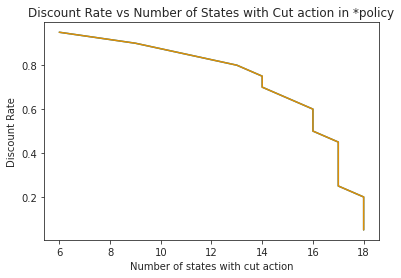

In [ ]:
plt.plot(test1[:,1],test1[:,0])
plt.plot(test2[:,1],test2[:,0])
plt.title("Discount Rate vs Number of States with Cut action in *policy")
plt.xlabel("Number of states with cut action")
plt.ylabel("Discount Rate")
print(policy.policy)
print(policy2.policy)

In [ ]:
test1 =  np.zeros((19,2))
test2 = np.zeros((19,2))
for i in range(19):
  np.random.seed(0)
  P, R = mdptoolbox.example.forest(S=20,r1 = i+1)
  disc = .8
  
  policy = mdptoolbox.mdp.PolicyIteration(P,R,discount = disc)
  #policy.setVerbose() 
  policy.run()
  
  test1[i,1] = policy.policy.count(1)
  test1[i,0] = i+1
  policy2 = mdptoolbox.mdp.ValueIteration(P,R,disc)
  #policy2.setVerbose()
  policy2.run()
  test1[i,1] = policy2.policy.count(1)
  test1[i,0] = i+1

Text(0, 0.5, 'Final Reward for Uncut Forest')

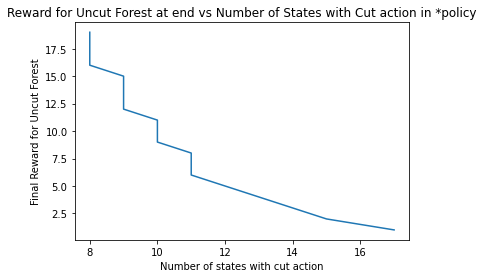

In [ ]:
plt.plot(test1[:,1],test1[:,0])
plt.title("Reward for Uncut Forest at end vs Number of States with Cut action in *policy")
plt.xlabel("Number of states with cut action")
plt.ylabel("Final Reward for Uncut Forest")

In [ ]:
np.random.seed(0)
lakeSize3 = 10
random_map = generate_random_map(size=lakeSize3, p=0.8)
 
enviro3 = gym.make("FrozenLake-v0", desc=random_map)
enviro3.reset()

0

In [ ]:
Q, stats, delta = testQ(enviro3, 52981, discount_factor=.8,alpha=.4,epsilon=1,eps_decay=.9999,alpha_decay=0.999)

0.004999762225088606


Text(0.5, 0, 'Episode #')

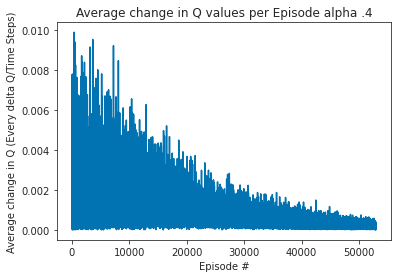

In [ ]:
plt.plot(delta[:,0])


plt.title("Average change in Q values per Episode alpha .4")
plt.ylabel("Average change in Q (Every delta Q/Time Steps)")
plt.xlabel("Episode #")

0.004999762225088606


Text(0.5, 0, 'Episode #')

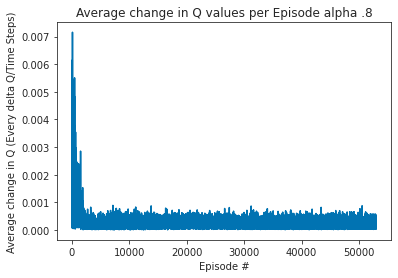

In [ ]:
Q, stats, delta = testQ(enviro3, 52981, discount_factor=.8,alpha=.4,epsilon=1,eps_decay=.9999)


In [226]:
Q, stats, delta = testQ(enviro3, 52981, discount_factor=.8,alpha=.4,epsilon=1,eps_decay=.9999,alpha_decay=.999)

0.004999762225088606


Text(0.5, 0, 'Episode #')

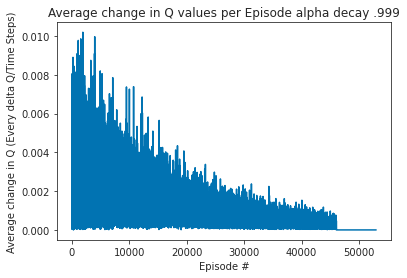

In [225]:
plt.plot(delta[:,0])


plt.title("Average change in Q values per Episode alpha decay .999")
plt.ylabel("Average change in Q (Every delta Q/Time Steps)")
plt.xlabel("Episode #")

In [234]:
print(np.reshape(np.argmax(Q,axis=1),(10,10)))

[[3 3 0 0 3 0 3 2 0 0]
 [0 0 3 1 0 2 0 2 0 0]
 [0 0 0 2 1 1 1 1 1 1]
 [3 1 1 3 3 3 3 3 3 3]
 [0 3 0 0 0 3 0 0 0 0]
 [0 0 2 3 1 0 0 1 1 1]
 [1 1 0 0 0 0 3 2 2 3]
 [3 0 0 1 2 1 0 0 2 1]
 [3 2 0 0 0 2 3 1 1 0]
 [1 3 0 0 3 2 3 3 3 0]]


In [235]:
enviro3.render()

  (Up)
SFFHFFFFFH
FHFFHFHFHF
FFHFFFFFFF
FFFFFFFFFF
HFFHHFFHFH
FHFFFHHFFF
FFFHHHFFFF
FFFFFFFHFF
FFFFHFFFFF
FFFHFFFFFG


In [ ]:

np.reshape(np.argmax(Q,axis = 1),(5,5))

array([[3, 1, 3, 3, 3],
       [0, 0, 0, 0, 2],
       [1, 0, 3, 0, 2],
       [3, 0, 0, 1, 0],
       [0, 2, 1, 1, 0]])

In [ ]:
enviro3.render()
print((np.asarray(stats.episode_rewards)>np.zeros(len(stats.episode_rewards))).sum())

  (Up)
SFFFF
FFHHF
FFFHF
FFHFH
HFFFG
7297


In [ ]:
np.random.seed(0)
lakeSize4 = 30
random_map = generate_random_map(size=lakeSize4, p=0.8)
 
enviro4 = gym.make("FrozenLake-v0", desc=random_map)
enviro4.reset()
Q, stats, delta = testQ(enviro4, 52981, discount_factor=.8,alpha=.4,epsilon=1,eps_decay=.9999,alpha_decay=.99995)

0.004999762225088606


Text(0.5, 0, 'Episode #')

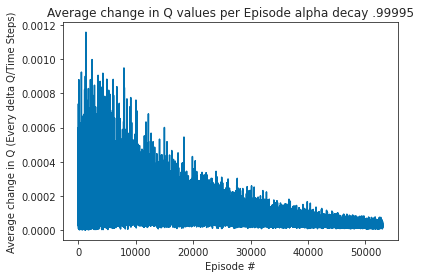

In [ ]:
plt.plot(delta[:,0])


plt.title("Average change in Q values per Episode alpha decay .99995")
plt.ylabel("Average change in Q (Every delta Q/Time Steps)")
plt.xlabel("Episode #")

In [236]:
q, stat, delt = qForest(20,100000,fire = .1,alpha = .8,alpha_decay=.95,discount_factor=.8,eps_decay = .999995)

0.6065299015452864


Text(0.5, 0, 'Episode #')

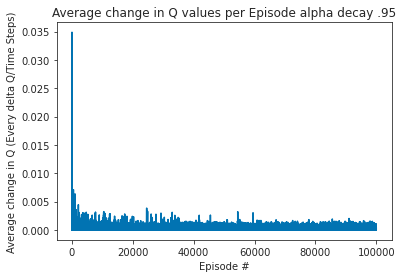

In [237]:
plt.plot(delt)


plt.title("Average change in Q values per Episode alpha decay .95")
plt.ylabel("Average change in Q (Every delta Q/Time Steps)")
plt.xlabel("Episode #")

In [ ]:
print(q)

[[1.0752271  0.68844339]
 [1.06745229 1.68869616]
 [1.04887535 1.68723085]
 [1.06308182 1.68947503]
 [1.04594118 1.68959385]
 [1.04137987 1.68583838]
 [1.07877577 1.68943736]
 [1.02088689 1.68846293]
 [0.60542426 1.65122729]
 [0.18289092 1.30159788]
 [0.01129858 0.67911224]
 [0.03313625 0.16260594]
 [0.03289918 0.        ]
 [0.01016795 0.        ]
 [0.         0.31289278]
 [0.         0.08506168]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


0.6065299015452864


Text(0.5, 0, 'Episode #')

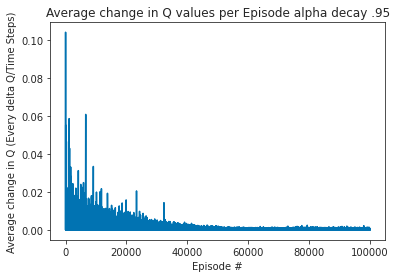

In [238]:
q, stat, delt = qForest(20,100000,fire = .1,alpha = .8,alpha_decay=.99995,discount_factor=.8,eps_decay = .999995)
plt.plot(delt)


plt.title("Average change in Q values per Episode alpha decay .95")
plt.ylabel("Average change in Q (Every delta Q/Time Steps)")
plt.xlabel("Episode #")

In [ ]:
policy = mdptoolbox.mdp.PolicyIteration(P,R,discount = .8)
 
policy.run()
print(policy.policy)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
